Training with CPU ...
[13:08:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-error:0.32780
[1]	test-error:0.32900
[2]	test-error:0.32360
[3]	test-error:0.32080
[4]	test-error:0.31640
[5]	test-error:0.31080
[6]	test-error:0.30900
[7]	test-error:0.30720
[8]	test-error:0.30400
[9]	test-error:0.30560
[10]	test-error:0.30340
[11]	test-error:0.30400
[12]	test-error:0.29880
[13]	test-error:0.29940
[14]	test-error:0.29880
[15]	test-error:0.29640
[16]	test-error:0.29500
[17]	test-error:0.29480
[18]	test-error:0.29600
[19]	test-error:0.29280
[20]	test-error:0.29400
[21]	test-error:0.29460
[22]	test-error:0.29360
[23]	test-error:0.29340
[24]	test-error:0.29120
[25]	test-error:0.29280
[26]	test-error:0.29280
[27]	test-erro

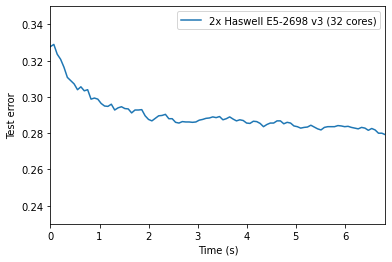

In [10]:
import csv
import numpy as np
import os.path
import pandas
import time
import xgboost as xgb
import sys

if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
dmatrix_train_filename = "higgs_train.dmatrix"
dmatrix_test_filename = "higgs_test.dmatrix"
csv_filename = "HIGGS.csv.gz"
train_rows = 100000
test_rows = 5000
num_round = 100

plot = True

# return xgboost dmatrix
def load_higgs():
    if os.path.isfile(dmatrix_train_filename) and os.path.isfile(dmatrix_test_filename):           
        dtrain = xgb.DMatrix(dmatrix_train_filename)
        dtest = xgb.DMatrix(dmatrix_test_filename)
        if dtrain.num_row() == train_rows and dtest.num_row() == test_rows:
            print("Loading cached dmatrix...")
            return dtrain, dtest

    if not os.path.isfile(csv_filename):
        print("Downloading higgs file...")
        urlretrieve(data_url, csv_filename)

    df_higgs_train = pandas.read_csv(csv_filename, dtype=np.float32, 
                                     nrows=train_rows, header=None)
    dtrain = xgb.DMatrix(df_higgs_train.iloc[:, 1:29], df_higgs_train[0])
    dtrain.save_binary(dmatrix_train_filename)
    df_higgs_test = pandas.read_csv(csv_filename, dtype=np.float32, 
                                    skiprows=train_rows, nrows=test_rows, 
                                    header=None)
    dtest = xgb.DMatrix(df_higgs_test.iloc[:, 1:29], df_higgs_test[0])
    dtest.save_binary(dmatrix_test_filename)

    return dtrain, dtest


dtrain, dtest = load_higgs()
param = {}
param['objective'] = 'binary:logitraw'
param['eval_metric'] = 'error'
param['tree_method'] = 'gpu_hist'
param['silent'] = 1

# print("Training with GPU ...")
# tmp = time.time()
# gpu_res = {}
# xgb.train(param, dtrain, num_round, evals=[(dtest, "test")], 
#           evals_result=gpu_res)
# gpu_time = time.time() - tmp
# print("GPU Training Time: %s seconds" % (str(gpu_time)))

print("Training with CPU ...")
param['tree_method'] = 'hist'
tmp = time.time()
cpu_res = {}
xgb.train(param, dtrain, num_round, evals=[(dtest, "test")], evals_result=cpu_res)
cpu_time = time.time() - tmp
print("CPU Training Time: %s seconds" % (str(cpu_time)))

if plot:
    import matplotlib.pyplot as plt
#     min_error = min(min(gpu_res["test"][param['eval_metric']]), 
#                     min(cpu_res["test"][param['eval_metric']]))
#     gpu_iteration_time = [x / (num_round * 1.0) * gpu_time for x in range(0, num_round)]
    cpu_iteration_time =  [x / (num_round * 1.0) * cpu_time for x in range(0, num_round)]
#     plt.plot(gpu_iteration_time, gpu_res['test'][param['eval_metric']], 
#              label='Tesla P100')
    plt.plot(cpu_iteration_time, cpu_res['test'][param['eval_metric']], label='2x Haswell E5-2698 v3 (32 cores)')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Test error')
#     plt.axhline(y=min_error, color='r', linestyle='dashed')
    plt.margins(x=0)
    plt.ylim((0.23, 0.35))
    plt.show()